In [138]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# ML & preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


# Imbalanced
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

# External models
try:
    from xgboost import XGBClassifier
except Exception:
    XGBClassifier = None
try:
    from lightgbm import LGBMClassifier
except Exception:
    LGBMClassifier = None

# XAI (optional)
try:
    import shap
except Exception:
    shap = None
try:
    from lime.lime_tabular import LimeTabularExplainer
except Exception:
    LimeTabularExplainer = None

# I/O
import json
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('Dataset-/patient_adherence_dataset.csv')

In [140]:
df.head(10)

,Age,Gender,Medication_Type,Dosage_mg,Previous_Adherence,Education_Level,Income,Social_Support_Level,Condition_Severity,Comorbidities_Count,Healthcare_Access,Mental_Health_Status,Insurance_Coverage,Adherence
0,57,Male,TypeA,136,1,High School,634934,Medium,Severe,3,Poor,Good,1,1
1,47,Male,TypeA,134,1,High School,297954,High,Moderate,3,Good,Good,1,0
2,59,Male,TypeC,89,1,High School,789337,High,Moderate,1,Good,Good,1,1
3,72,Male,TypeB,240,0,Postgraduate,267352,Low,Mild,2,Poor,Moderate,1,0
4,46,Male,TypeA,241,1,Postgraduate,718447,Medium,Mild,1,Poor,Good,1,0
5,46,Female,TypeA,242,1,Graduate,389971,Medium,Mild,1,Good,Good,1,1
6,73,Female,TypeA,215,1,High School,532785,Low,Mild,1,Poor,Good,1,1
7,61,Female,TypeC,93,1,High School,545197,Low,Mild,0,Poor,Good,1,1
8,42,Male,TypeA,148,1,Postgraduate,539541,High,Moderate,1,Poor,Good,1,1
9,58,Male,TypeC,208,1,Postgraduate,634899,Low,Mild,2,Average,Good,1,1


In [141]:
df.shape

(5000, 14)

# Definisi Fitur

In [142]:
numerical_features = ['Age', 'Dosage_mg', 'Previous_Adherence', 'Income', 'Comorbidities_Count', 'Insurance_Coverage']
kategorical_features = ['Gender', 'Medication_Type', 'Education_Level', 'Social_Support_Level', 'Condition_Severity', 'Healthcare_Access', 'Mental_Health_Status']

target_features = 'Adherence'

In [143]:
# Missing Numerik -> Median
for col in numerical_features:
    df[col] = df[col].fillna(df[col].median())

# Missing Kategorik -> 'Uknown'
for col in kategorical_features:
    df[col] = df[col].fillna('Unknown')

# One-Hot Encoding
df = pd.get_dummies(df, columns=kategorical_features, drop_first=True)
print("Data setelah penanganan missing values dan encoding:")
df.head(5)

Data setelah penanganan missing values dan encoding:


,Age,Dosage_mg,Previous_Adherence,Income,Comorbidities_Count,Insurance_Coverage,Adherence,Gender_Male,Gender_Other,Medication_Type_TypeB,...,Education_Level_High School,Education_Level_Postgraduate,Social_Support_Level_Low,Social_Support_Level_Medium,Condition_Severity_Moderate,Condition_Severity_Severe,Healthcare_Access_Good,Healthcare_Access_Poor,Mental_Health_Status_Moderate,Mental_Health_Status_Poor
0,57,136,1,634934,3,1,1,True,False,False,...,True,False,False,True,False,True,False,True,False,False
1,47,134,1,297954,3,1,0,True,False,False,...,True,False,False,False,True,False,True,False,False,False
2,59,89,1,789337,1,1,1,True,False,False,...,True,False,False,False,True,False,True,False,False,False
3,72,240,0,267352,2,1,0,True,False,True,...,False,True,True,False,False,False,False,True,True,False
4,46,241,1,718447,1,1,0,True,False,False,...,False,True,False,True,False,False,False,True,False,False


In [144]:
X = df.drop(columns=[target_features])
y = df[target_features]

if not set(y.unique()).issubset({0, 1}):
    mapping = {v: i for i, v in enumerate(y.unique())}
    y = y.map(mapping)
    print("\nMapping target dilakukan:", mapping)

# Train Test Split

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [146]:
# Scalling numerik features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTrain/Test Size:", X_train.shape, X_test.shape)


Train/Test Size: (4000, 20) (1000, 20)


In [147]:
X_train_scaled = np.array(X_train_scaled)
X_test_scaled = np.array(X_test_scaled)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Model & Parameter

In [148]:
models_param = {}

# 1 Logistic Regression
models_param['LogisticRegression'] = {
    'model': LogisticRegression(max_iter=2000, random_state=42),
    'params': {'C': [0.01,0.1,1,10], 'class_weight': [None,'balanced']}
}

# 2 Decision Tree
models_param['DecisionTree'] = {
    'model': DecisionTreeClassifier(random_state=42),
    'params': {'max_depth': [3,5,10,None], 'min_samples_split': [2,5,10]}
}

# 3 Random Forest
models_param['RandomForest'] = {
    'model': RandomForestClassifier(random_state=42),
    'params': {'n_estimators':[100,200,300], 'max_depth':[None,5,10], 'class_weight':[None,'balanced']}
}

# 4 GradientBoosting (sklearn)
models_param['GradientBoosting'] = {
    'model': GradientBoostingClassifier(random_state=42),
    'params': {'n_estimators':[100,200], 'learning_rate':[0.05,0.1], 'max_depth':[3,5]}
}

# 5 XGBoost
if XGBClassifier is not None:
    models_param['XGBoost'] = {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {'n_estimators':[100,200], 'learning_rate':[0.05,0.1], 'max_depth':[3,5], 'subsample':[0.7,1.0]}
    }
else:
    print("XGBoost not available — skipped.")

# 6 LightGBM
if LGBMClassifier is not None:
    models_param['LightGBM'] = {
        'model': LGBMClassifier(random_state=42),
        'params': {'n_estimators':[100,200], 'learning_rate':[0.05,0.1], 'num_leaves':[31,64]}
    }
else:
    print("LightGBM not available — skipped.")


# 7 MLP
models_param['MLP'] = {
    'model': MLPClassifier(max_iter=1000, random_state=42),
    'params': {'hidden_layer_sizes':[(50,),(100,)], 'alpha':[1e-4,1e-3], 'learning_rate_init':[1e-3,1e-2]}
}

# 8 SVM
models_param['SVM'] = {
    'model': SVC(probability=True, random_state=42),
    'params': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    }
}

# 9 Naive Bayes
models_param['NB'] = {
    'model': GaussianNB(),
    'params': {
        'var_smoothing': [1e-9, 1e-8, 1e-7]
    }
}

# 9 KNN
models_param['KNN'] = {
    'model': KNeighborsClassifier(),
    'params': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]   # Manhattan (1) & Euclidean (2)
    }
}




In [149]:
print("Model Machine Learning:", list(models_param.keys()))


Model Machine Learning: ['LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM', 'MLP', 'SVM', 'NB', 'KNN']


# Manual Randomized Search with SMOTE per fold

In [150]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [151]:
results_summary = []

for name in models_param.keys():

    print(f"\n===== TUNING MODEL: {name} =====")

    params_grid = models_param[name]['params']
    base_model = models_param[name]['model']
    model_class = base_model.__class__

    sampler = ParameterSampler(params_grid, n_iter=5, random_state=42)

    best_score = 0
    best_param = None

    for params in sampler:
        model = model_class(**params)
        fold_scores = []

        for train_idx, val_idx in skf.split(X_train_scaled, y_train):
            X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

            smote = SMOTE(random_state=42)
            X_res, y_res = smote.fit_resample(X_train_fold, y_train_fold)

            model.fit(X_res, y_res)
            preds = model.predict(X_val_fold)

            f1 = f1_score(y_val_fold, preds)
            fold_scores.append(f1)

        avg_score = sum(fold_scores) / len(fold_scores)

        if avg_score > best_score:
            best_score = avg_score
            best_param = params

    print("Best param:", best_param, " Best F1:", best_score)

    # Retrain final model
    final_model = model_class(**best_param)

    smote = SMOTE(random_state=42)
    X_res_full, y_res_full = smote.fit_resample(X_train_scaled, y_train)
    final_model.fit(X_res_full, y_res_full)



===== TUNING MODEL: LogisticRegression =====
Best param: {'class_weight': 'balanced', 'C': 0.01}  Best F1: 0.6274967071352849

===== TUNING MODEL: DecisionTree =====
Best param: {'min_samples_split': 10, 'max_depth': 5}  Best F1: 0.6106363530244112

===== TUNING MODEL: RandomForest =====
Best param: {'n_estimators': 100, 'max_depth': 5, 'class_weight': None}  Best F1: 0.6240675831452975

===== TUNING MODEL: GradientBoosting =====
Best param: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}  Best F1: 0.607958719111903

===== TUNING MODEL: XGBoost =====
Best param: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}  Best F1: 0.6150558784291936

===== TUNING MODEL: LightGBM =====
[LightGBM] [Info] Number of positive: 1736, number of negative: 1736
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `

In [153]:
# Dictionary untuk menyimpan hasil akhir tiap model
if 'results_summary' not in globals():
    results_summary = []

results_summary.append({
    'Model': name,
    'Best_F1': best_score,
    'Best_Params': best_param
})


In [154]:
results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values(by='Best_F1', ascending=False).reset_index(drop=True)
results_df

,Model,Best_F1,Best_Params
0,KNN,0.585704,"{'weights': 'uniform', 'p': 2, 'n_neighbors': 9}"


In [161]:
y_pred = final_model.predict(X_test_scaled)

# Hitung AUC secara aman (untuk berbagai jenis model)
auc = None
if hasattr(final_model, "predict_proba"):
    y_proba = final_model.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
elif hasattr(final_model, "decision_function"):
    y_proba = final_model.decision_function(X_test_scaled)
    auc = roc_auc_score(y_test, y_proba)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("AUC:", auc)

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.53      0.58       543
           1       0.54      0.65      0.59       457

    accuracy                           0.59      1000
   macro avg       0.59      0.59      0.59      1000
weighted avg       0.60      0.59      0.59      1000

Confusion Matrix:
[[290 253]
 [160 297]]
AUC: 0.6214059181707913


# SHAP — GLOBAL EXPLAINABILITY

In [162]:
feature_names = X.columns.tolist()

# Identifikasi tipe model
model_name = type(final_model).__name__
tree_models = (
    'RandomForest', 'DecisionTree', 'GradientBoosting',
    'XGB', 'XGBoost', 'LGBM', 'LightGBM'
)

print("\nRunning SHAP for model:", model_name)


Running SHAP for model: KNeighborsClassifier


In [182]:
import shap

if shap is None:
    print("SHAP tidak tersedia, pasang paket shap terlebih dahulu.")
else:
    # Fungsi prediksi probabilitas/score untuk model non-tree
    if hasattr(final_model, "predict_proba"):
        predict_fn = lambda data: final_model.predict_proba(data)[:, 1]
    elif hasattr(final_model, "decision_function"):
        predict_fn = lambda data: final_model.decision_function(data)
    else:
        predict_fn = None

    background = shap.utils.sample(X_train_scaled, min(200, len(X_train_scaled))) if hasattr(shap.utils, "sample") else X_train_scaled
    eval_data = shap.utils.sample(X_train_scaled, min(200, len(X_train_scaled))) if hasattr(shap.utils, "sample") else X_train_scaled

    shap_values_raw = None
    is_tree_model = any(key in model_name for key in tree_models)

    try:
        if is_tree_model:
            explainer = shap.TreeExplainer(final_model, feature_perturbation="interventional")
            shap_values_raw = explainer.shap_values(eval_data)
        elif predict_fn is not None:
            explainer = shap.Explainer(predict_fn, background)
            shap_values_raw = explainer(eval_data).values
    except Exception as e:
        print(f"Explainer standar gagal: {e}")

    # Fallback ke KernelExplainer bila masih gagal (mis. KNN)
    if shap_values_raw is None and predict_fn is not None:
        try:
            explainer = shap.KernelExplainer(predict_fn, background)
            shap_values_raw = explainer.shap_values(eval_data, nsamples=100)
        except Exception as e:
            print(f"Gagal menghitung SHAP (kernel): {e}")
            shap_values_raw = None

    # Normalisasi bentuk keluaran ke matriks (n_sample, n_feature) untuk kelas positif
    if shap_values_raw is not None:
        if isinstance(shap_values_raw, list):
            shap_values_pos = shap_values_raw[1] if len(shap_values_raw) > 1 else shap_values_raw[0]
        elif hasattr(shap_values_raw, "ndim") and shap_values_raw.ndim == 3 and shap_values_raw.shape[1] > 1:
            shap_values_pos = shap_values_raw[:, 1, :]
        else:
            shap_values_pos = shap_values_raw

        n_features = X_train_scaled.shape[1]
        shap_values_pos = np.array(shap_values_pos)[:, :n_features]
    else:
        shap_values_pos = None

PermutationExplainer explainer: 201it [01:45,  1.90it/s]                         


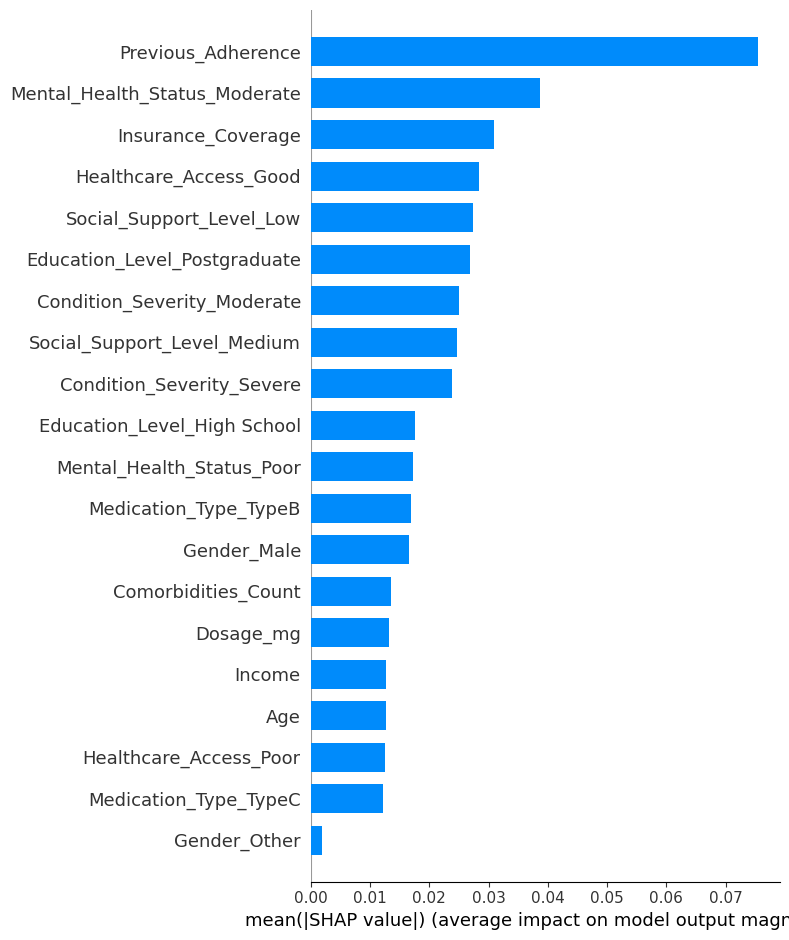

In [183]:
# Plot SHAP summary (bar) jika tersedia
if shap is not None and shap_values_pos is not None:
    shap.summary_plot(shap_values_pos, features=eval_data, feature_names=feature_names, plot_type="bar", show=False)
    plt.tight_layout()
    plt.show()
else:
    print("SHAP values belum tersedia untuk plotting.")

# LIME — LOCAL EXPLAINABILITY

In [187]:
# Install LIME jika belum terpasang
try:
    import lime
    from lime.lime_tabular import LimeTabularExplainer
    print("LIME sudah tersedia.")
except Exception:
    import sys, subprocess
    print("Menginstal paket lime...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lime"])
    from lime.lime_tabular import LimeTabularExplainer
    print("LIME berhasil diinstal.")

LIME sudah tersedia.


In [190]:
if LimeTabularExplainer is None:
    print("LIME tidak tersedia, pasang paket lime terlebih dahulu.")
else:
    # Siapkan fungsi prediksi (proba atau decision_function)
    if hasattr(final_model, "predict_proba"):
        predict_fn = lambda data: final_model.predict_proba(data)
    elif hasattr(final_model, "decision_function"):
        predict_fn = lambda data: np.vstack([
            1 - (1 / (1 + np.exp(-final_model.decision_function(data)))),
            1 / (1 + np.exp(-final_model.decision_function(data)))
        ]).T
    else:
        predict_fn = None

    if predict_fn is None:
        print("Model tidak memiliki predict_proba/decision_function; LIME dibatalkan.")
    else:
        # LIME memakai data yang sudah diskalakan
        lime_explainer = LimeTabularExplainer(
            training_data=X_train_scaled,
            feature_names=feature_names,
            class_names=['Non-Adherent', 'Adherent'],
            discretize_continuous=True,
            verbose=False
        )

        sample_idx = 0  # ubah indeks ini bila ingin contoh lain
        lime_exp = lime_explainer.explain_instance(
            data_row=X_test_scaled[sample_idx],
            predict_fn=predict_fn,
            num_features=10,
            top_labels=2
        )

        # Header
        print(f"\n{'='*70}")
        print(f"🔬 LIME LOCAL EXPLAINABILITY - Sample {sample_idx}")
        print(f"{'='*70}")
        
        # Prediction Probability
        print(f"\n📊 Prediction Probabilities:")
        print(f"   • Non-Adherent (0): {lime_exp.predict_proba[0]:.4f} ({lime_exp.predict_proba[0]*100:.2f}%)")
        print(f"   • Adherent (1):     {lime_exp.predict_proba[1]:.4f} ({lime_exp.predict_proba[1]*100:.2f}%)")
        


🔬 LIME LOCAL EXPLAINABILITY - Sample 0

📊 Prediction Probabilities:
   • Non-Adherent (0): 0.5556 (55.56%)
   • Adherent (1):     0.4444 (44.44%)


In [191]:
# Feature Contributions Table
print(f"\n📋 Top 10 Feature Contributions for Adherent Class:")
lime_df = pd.DataFrame(lime_exp.as_list(label=1), columns=['Feature', 'Weight'])
display(lime_df.style.background_gradient(cmap='RdYlGn', subset=['Weight']))


📋 Top 10 Feature Contributions for Adherent Class:


,Feature,Weight
0,Mental_Health_Status_Moderate <= -0.65,0.076041
1,Condition_Severity_Severe > -0.50,-0.075825
2,Healthcare_Access_Poor > -0.50,-0.074629
3,Education_Level_Postgraduate <= -0.49,-0.074402
4,Condition_Severity_Moderate <= -0.64,0.063734
5,Gender_Other <= -0.12,0.057406
6,Healthcare_Access_Good <= -0.81,-0.046896
7,Mental_Health_Status_Poor <= -0.51,0.046262
8,Social_Support_Level_Low <= -0.66,0.041176
9,-0.60 < Medication_Type_TypeC <= 1.67,-0.037764



 Feature Importance Visualization:


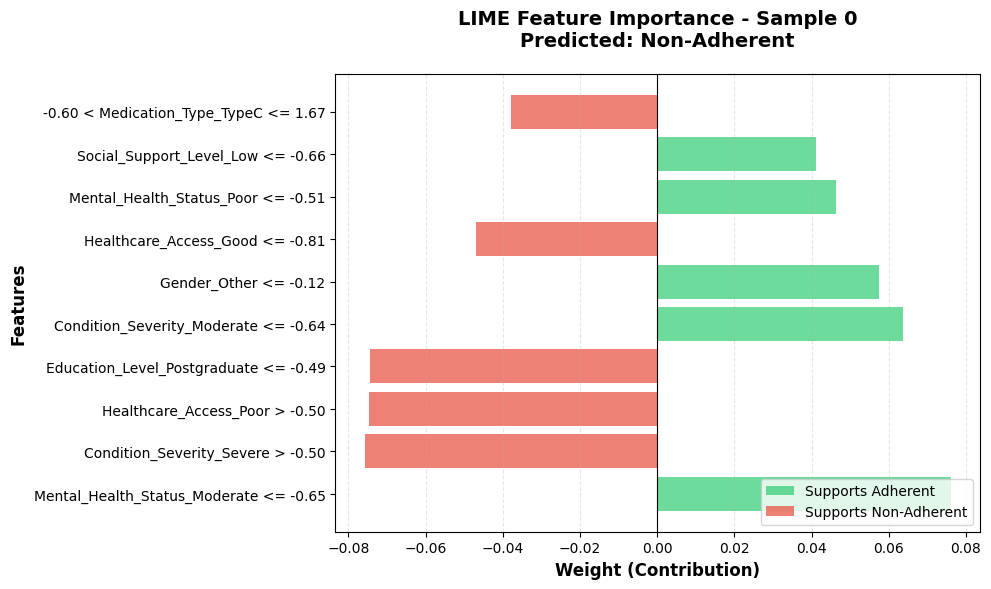

In [193]:
# Visualisasi Bar Chart
print(f"\n Feature Importance Visualization:")
fig, ax = plt.subplots(figsize=(10, 6))
        
features = [x[0] for x in lime_exp.as_list(label=1)]
weights = [x[1] for x in lime_exp.as_list(label=1)]
        
colors = ['#2ecc71' if w > 0 else '#e74c3c' for w in weights]
bars = ax.barh(features, weights, color=colors, alpha=0.7)
        
# Styling
ax.set_xlabel('Weight (Contribution)', fontsize=12, fontweight='bold')
ax.set_ylabel('Features', fontsize=12, fontweight='bold')
ax.set_title(f'LIME Feature Importance - Sample {sample_idx}\nPredicted: {"Adherent" if lime_exp.predict_proba[1] > 0.5 else "Non-Adherent"}', 
                     fontsize=14, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3, linestyle='--')
        
# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', alpha=0.7, label='Supports Adherent'),
    Patch(facecolor='#e74c3c', alpha=0.7, label='Supports Non-Adherent')
    ]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
        
plt.tight_layout()
plt.show()